In [1]:
import warnings
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from tqdm import tqdm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings('ignore')
font_path = "C:/Windows/Fonts/Malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
data_path = '../R/.R연관분석/data'

df = pd.read_csv(f"{data_path}/CUST_ORDER_OUTPUT2.utf8.csv")
df.head()

,CUST_SERIAL_NO,SEX,AGE,REG_DATE,ORDER_DATE,ORDER_HOUR,ORDER_WEEKDAY,IS_WEEKEND,GOODS_CODE,LGROUP,MGROUP,SGROUP,DGROUP,GOODS_NAME,PRICE,QTY
0,1000000023,F,40,2011-07,2011-11-14,"[0, 3[",토,T,20261,20,2,1,1,더무료체험,61500,1
1,1000000023,F,40,2011-07,2012-05-28,"[0, 3[",토,T,20728,10,10,3,1,메쉬런닝화 + 슈즈 2종 여성,42500,1
2,1000000023,F,40,2011-07,2012-05-28,"[0, 3[",토,T,20729,10,10,1,1,메쉬런닝화 + 슈즈 2종 남성,42500,1
3,1000000014,F,60,2011-07,2011-08-30,"[0, 3[",일,T,20062,70,2,1,4,왕만두 16봉 구성 +추가구성 참치,53400,1
4,1000000014,F,60,2011-07,2011-08-30,"[0, 3[",일,T,20133,70,2,1,11,베스트셀러 5종,33400,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510470 entries, 0 to 510469
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   CUST_SERIAL_NO  510470 non-null  int64 
 1   SEX             510470 non-null  object
 2   AGE             510470 non-null  object
 3   REG_DATE        510470 non-null  object
 4   ORDER_DATE      510470 non-null  object
 5   ORDER_HOUR      510470 non-null  object
 6   ORDER_WEEKDAY   510470 non-null  object
 7   IS_WEEKEND      510470 non-null  object
 8   GOODS_CODE      510470 non-null  int64 
 9   LGROUP          510470 non-null  int64 
 10  MGROUP          510470 non-null  int64 
 11  SGROUP          510470 non-null  int64 
 12  DGROUP          510470 non-null  int64 
 13  GOODS_NAME      510470 non-null  object
 14  PRICE           510470 non-null  int64 
 15  QTY             510470 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 62.3+ MB


In [4]:
df.describe()

,CUST_SERIAL_NO,GOODS_CODE,LGROUP,MGROUP,SGROUP,DGROUP,PRICE,QTY
count,5.104700e+05,510470.000000,510470.000000,510470.000000,510470.000000,510470.000000,5.104700e+05,510470.000000
mean,1.000195e+09,20514.289880,44.490646,3.908124,7.230333,4.170921,7.996262e+04,1.059608
std,1.210115e+05,237.792786,25.044587,4.203214,5.630811,3.367291,6.446042e+04,0.391599
min,1.000000e+09,20001.000000,10.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000
25%,1.000089e+09,20313.000000,20.000000,1.000000,2.000000,2.000000,4.430000e+04,1.000000
50%,1.000189e+09,20517.000000,50.000000,2.000000,6.000000,3.000000,6.340000e+04,1.000000
75%,1.000297e+09,20729.000000,70.000000,4.000000,11.000000,5.000000,9.950000e+04,1.000000
max,1.000419e+09,20981.000000,85.000000,14.000000,27.000000,26.000000,3.979500e+06,10.000000


In [5]:
df = df[df['SEX'] != '*']
pd.unique(df['SEX'])

array(['F', 'M'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507352 entries, 0 to 507351
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   CUST_SERIAL_NO  507352 non-null  int64 
 1   SEX             507352 non-null  object
 2   AGE             507352 non-null  object
 3   REG_DATE        507352 non-null  object
 4   ORDER_DATE      507352 non-null  object
 5   ORDER_HOUR      507352 non-null  object
 6   ORDER_WEEKDAY   507352 non-null  object
 7   IS_WEEKEND      507352 non-null  object
 8   GOODS_CODE      507352 non-null  int64 
 9   LGROUP          507352 non-null  int64 
 10  MGROUP          507352 non-null  int64 
 11  SGROUP          507352 non-null  int64 
 12  DGROUP          507352 non-null  int64 
 13  GOODS_NAME      507352 non-null  object
 14  PRICE           507352 non-null  int64 
 15  QTY             507352 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 65.8+ MB


In [7]:
# 구매일자, 성별, 구매 건수만 추출하여 별도의 데이터 프레임을 만든다.
sex1 = df[['ORDER_DATE', 'SEX', 'QTY']]
sex1.head()

,ORDER_DATE,SEX,QTY
0,2011-11-14,F,1
1,2012-05-28,F,1
2,2012-05-28,F,1
3,2011-08-30,F,1
4,2011-08-30,F,1


In [8]:
# ORDER_DATE 열에 저장되어 있는 날짜를 이용하여 month 함수로 월만 추출해서 month 라는 새로운 열을 추가한다.
sex2 = sex1.copy()
sex2['month'] = pd.DatetimeIndex(sex1['ORDER_DATE']).month
sex2.head()

,ORDER_DATE,SEX,QTY,month
0,2011-11-14,F,1,11
1,2012-05-28,F,1,5
2,2012-05-28,F,1,5
3,2011-08-30,F,1,8
4,2011-08-30,F,1,8


In [9]:
# 성별로 구분하여 월별 구매 건수의 총합을 구해서 확인한다.
tmp = sex2.groupby(['month', 'SEX'])['QTY'].sum()
tmp1 = tmp.unstack()
tmp1

SEX,F,M
month,,
1,29851,15168
2,26487,11039
3,27142,12254
4,37208,17452
5,54211,30301
6,44600,29998
7,51767,40917
8,19478,11186
9,5168,1870


In [10]:
# F나 M 대신 female, male이라고 표시하기 위해서 변환 함수를 만들어서 적용하여 gender라는 열을 추가한다.
def change_gender(x):
    if x == 'M':
        return 'male'
    else:
        return 'female'


sex2['gender'] = sex2['SEX'].apply(lambda x: change_gender(x))
pd.unique(sex2['gender'])

array(['female', 'male'], dtype=object)

<AxesSubplot:xlabel='month'>

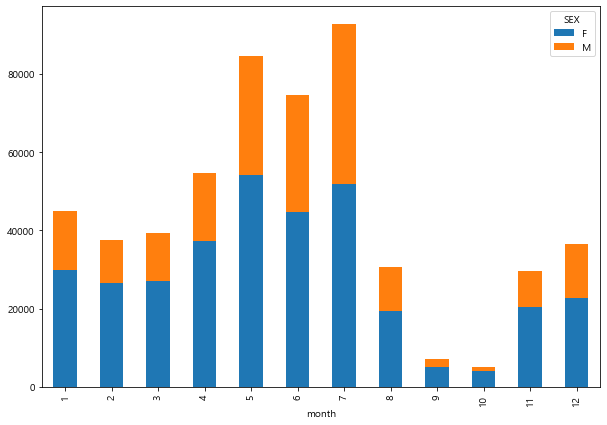

In [11]:
# 성별 별로 월별 구매 건수를 누적 막대 그래프로 표시한다.
tmp1.plot(kind='bar', stacked=True, figsize=(10, 7))

<AxesSubplot:title={'center':'male'}, xlabel='month'>

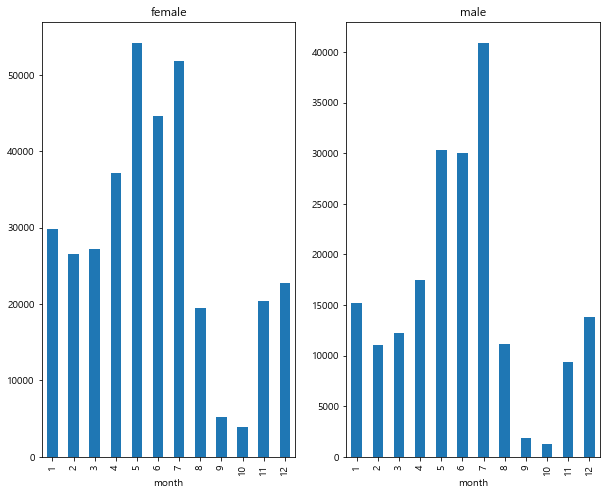

In [12]:
# 성별 별로 월별 구매 건수를 별도의 막대 그래프로 표시한다.
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('female')
sex2[sex2['gender'] == 'female'].groupby(['month'
                                          ])['QTY'].sum().plot(kind='bar')

plt.subplot(1, 2, 2)
plt.title('male')
sex2[sex2['gender'] == 'male'].groupby(['month'])['QTY'].sum().plot(kind='bar')

In [13]:
# 연령대 구매 건수
# 구매일자, 나이, 구매 건수 만 추출하여 별도의 데이터 프레임을 만든다.
age1 = df[["ORDER_DATE", "AGE", "QTY"]]
age1.head()

,ORDER_DATE,AGE,QTY
0,2011-11-14,40,1
1,2012-05-28,40,1
2,2012-05-28,40,1
3,2011-08-30,60,1
4,2011-08-30,60,1


In [14]:
# ORDER_DATE 열에 저장되어 있는 날짜를 이용하여 month 함수로 월만 추출해서 month 라는 새로운 열을 추가한다.
age2 = age1.copy()
age2['AGE'] = age2['AGE'].astype(int)
age2['month'] = pd.DatetimeIndex(age1['ORDER_DATE']).month
age2.head()

,ORDER_DATE,AGE,QTY,month
0,2011-11-14,40,1,11
1,2012-05-28,40,1,5
2,2012-05-28,40,1,5
3,2011-08-30,60,1,8
4,2011-08-30,60,1,8


In [15]:
# 연령별로 구분하여 월별 구매 건수의 총합을 구해서 확인한다.
tmp = age2.groupby(['month', 'AGE'])['QTY'].sum()
tmp1 = tmp.unstack()
tmp1

AGE,10,20,30,40,50,60,70,80,90,100
month,,,,,,,,,,
1,NaN,746.0,3929.0,10127.0,17580.0,9092.0,2546.0,294.0,439.0,266.0
2,NaN,849.0,3737.0,8752.0,14187.0,7045.0,1773.0,175.0,655.0,353.0
3,NaN,768.0,3708.0,9125.0,14960.0,7657.0,1943.0,188.0,699.0,348.0
4,NaN,820.0,4005.0,11520.0,21341.0,11589.0,2796.0,264.0,1969.0,356.0
5,NaN,1229.0,5574.0,17316.0,33268.0,16427.0,4033.0,384.0,3222.0,3059.0
6,8.0,1226.0,5751.0,15532.0,27510.0,13618.0,3361.0,244.0,4386.0,2962.0
7,NaN,1735.0,7336.0,18810.0,33338.0,16935.0,4061.0,272.0,6211.0,3986.0
8,NaN,540.0,2781.0,7098.0,11713.0,5531.0,1182.0,56.0,1310.0,453.0
9,NaN,131.0,820.0,2041.0,2455.0,1231.0,329.0,10.0,17.0,4.0


<AxesSubplot:xlabel='month'>

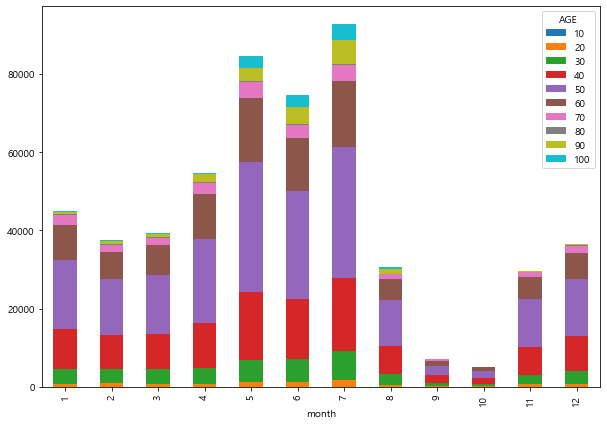

In [16]:
# 연령 별로 월별 구매 건수를 누적 막대 그래프로 표시한다.
tmp1.plot(kind='bar', stacked=True, figsize=(10, 7))

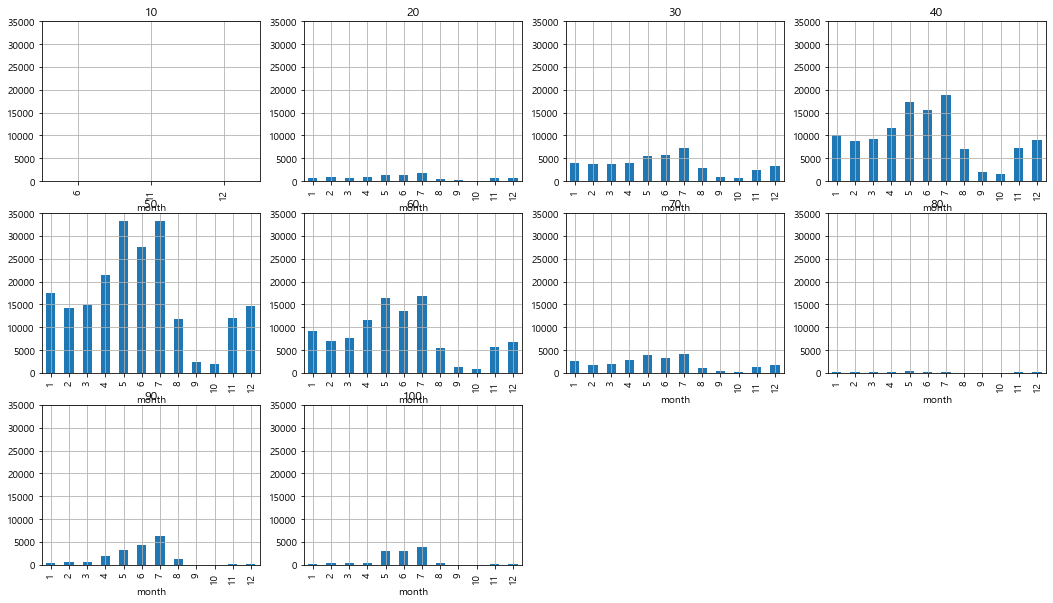

In [17]:
# 연령 별로 월별 구매 건수를 별도의 막대 그래프로 표시한다.
plt.figure(figsize=(18, 10))

for cnt in range(10):
    age = (cnt + 1) * 10
    plt.subplot(3, 4, cnt + 1)
    age2[age2['AGE'] == age].groupby('month')['QTY'].sum().plot(kind='bar')
    plt.title(age)
    plt.ylim((0, 35000))
    plt.grid(True)

plt.show()

In [18]:
# 성별/연령대 구매 건수
# 구매일자, 성별, 나이, 구매 건수만 추출하여 별도의 데이터 프레임을 만든다.
sex_age1 = df[["ORDER_DATE", "SEX", "AGE", "QTY"]]
sex_age1.head()

,ORDER_DATE,SEX,AGE,QTY
0,2011-11-14,F,40,1
1,2012-05-28,F,40,1
2,2012-05-28,F,40,1
3,2011-08-30,F,60,1
4,2011-08-30,F,60,1


In [19]:
sex_age1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507352 entries, 0 to 507351
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ORDER_DATE  507352 non-null  object
 1   SEX         507352 non-null  object
 2   AGE         507352 non-null  object
 3   QTY         507352 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 19.4+ MB


In [20]:
# ddply() 함수를 사용하여 날짜, 성별, 나이로 그룹을 지어 구매 수량을 합쳐서 확인한다.
sex_age2 = sex_age1.groupby(['ORDER_DATE', 'SEX', 'AGE']).sum().reset_index()
sex_age2['AGE'] = sex_age2['AGE'].astype(int)

In [21]:
# month() 함수로 월만 추출하여 month 열을 추가하고, ages 열에는 나이에 "대＂를 붙여서 추가한다.
sex_age3 = sex_age2.copy()
sex_age3['month'] = pd.DatetimeIndex(sex_age3['ORDER_DATE']).month
sex_age3['ages'] = sex_age3['AGE'].astype(str) + '대'
sex_age3.head()

,ORDER_DATE,SEX,AGE,QTY,month,ages
0,2011-07-14,F,20,5,7,20대
1,2011-07-14,M,30,20,7,30대
2,2011-07-15,F,20,6,7,20대
3,2011-07-15,M,30,4,7,30대
4,2011-07-16,F,20,4,7,20대


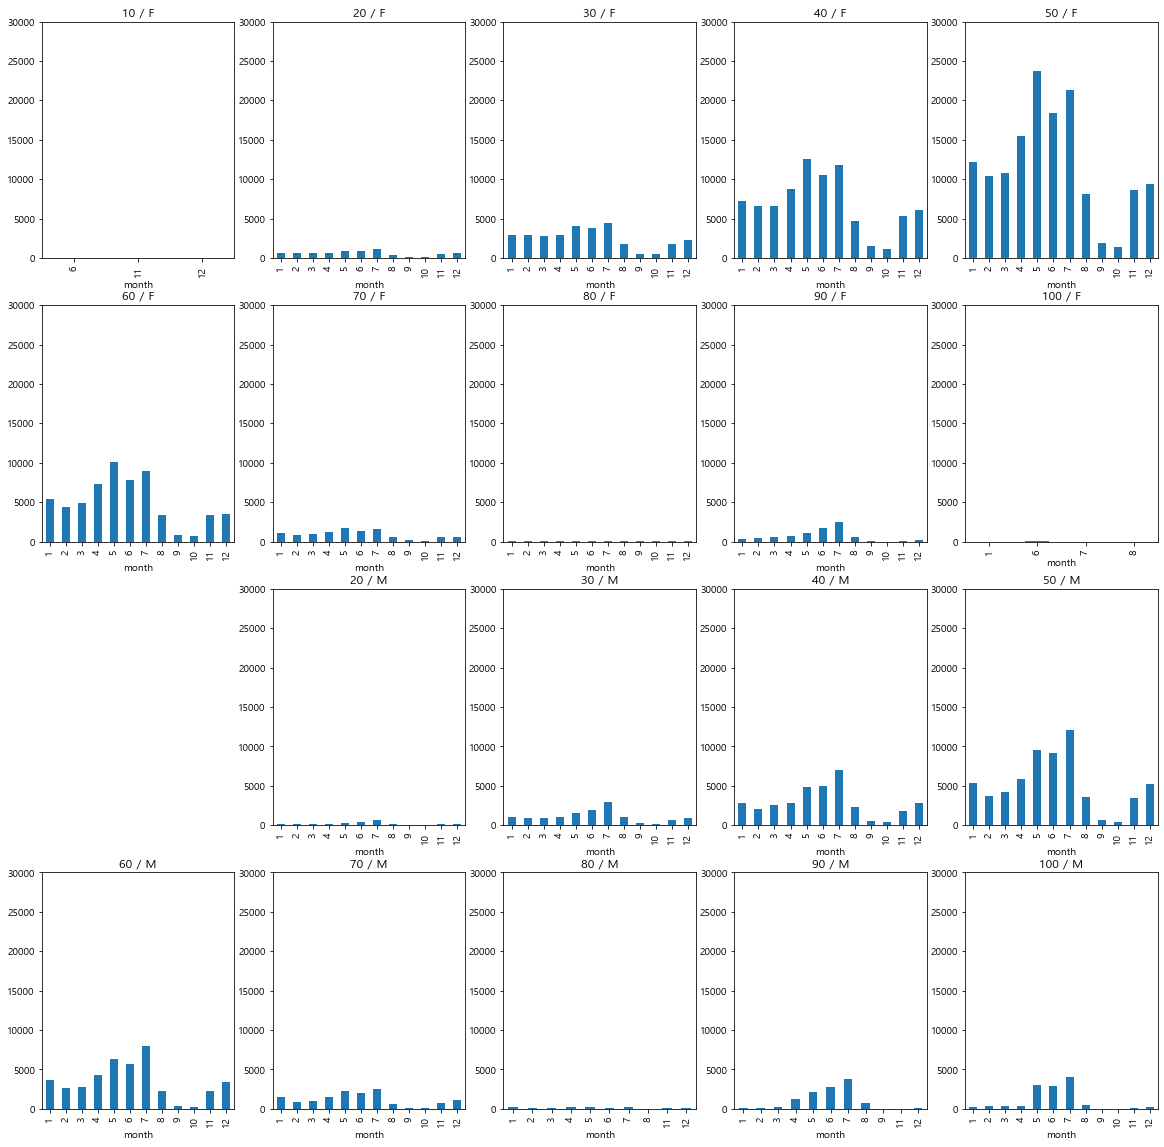

In [22]:
# 연령 별로 월별 구매 건수를 별도의 막대 그래프로 표시한다.
plt.figure(figsize=(20, 20))

for cnt in range(20):
    if cnt == 10: continue  # 10대 남자 데이터 없음
    age = (cnt + 1) * 10
    plt.subplot(4, 5, cnt + 1)
    sex = 'F'
    if cnt > 9:
        sex = 'M'
        age = (cnt - 9) * 10

    sex_age3[(sex_age3['SEX'] == sex)
             & (sex_age3['AGE'] == age)].groupby('month')['QTY'].sum().plot(
                 kind='bar')
    plt.ylim((0, 30000))
    plt.title(f'{age} / {sex}')

plt.show()

In [23]:
# 월별 고객단위 구매금액
# 구매일자, 고객 번호, 구매 금액 만 추출하여 별도의 데이터 프레임을 만든다.
cust1 = df[['ORDER_DATE', 'CUST_SERIAL_NO', 'PRICE']]
cust1.head()

,ORDER_DATE,CUST_SERIAL_NO,PRICE
0,2011-11-14,1000000023,61500
1,2012-05-28,1000000023,42500
2,2012-05-28,1000000023,42500
3,2011-08-30,1000000014,53400
4,2011-08-30,1000000014,33400


In [24]:
# month() 함수로 월만 추출하여 month 열을 추가한다.
cust2 = cust1.copy()
cust2['month'] = pd.DatetimeIndex(cust1['ORDER_DATE']).month
cust2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507352 entries, 0 to 507351
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ORDER_DATE      507352 non-null  object
 1   CUST_SERIAL_NO  507352 non-null  int64 
 2   PRICE           507352 non-null  int64 
 3   month           507352 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 19.4+ MB


In [25]:
# ddply() 함수를 사용하여 고객 번호와 월로 그룹을 지어 구매 금액을 합쳐서 확인한다.
cust3 = cust2.groupby(['CUST_SERIAL_NO', 'month'])['PRICE'].sum().reset_index()
cust3.head()

,CUST_SERIAL_NO,month,PRICE
0,1000000001,1,431900
1,1000000001,3,300200
2,1000000001,4,167900
3,1000000001,5,259700
4,1000000001,7,315000


In [26]:
# aggregate() 함수를 이용하여 고객 번호와 월을 기준으로 구매 금액을 합친다.
df2 = df.copy()
df2['month'] = pd.DatetimeIndex(df['ORDER_DATE']).month
agg_data = df2.groupby(['CUST_SERIAL_NO',
                        'month'])['PRICE'].sum().reset_index()
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452093 entries, 0 to 452092
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   CUST_SERIAL_NO  452093 non-null  int64
 1   month           452093 non-null  int64
 2   PRICE           452093 non-null  int64
dtypes: int64(3)
memory usage: 10.3 MB


In [27]:
# 그래프의 범례로 사용하기 위해 월에 "월＂을 붙여서 real_month라는 열을 추가한다.
agg_data['real_month'] = agg_data['month'].astype(str) + '월'
agg_data.head()

,CUST_SERIAL_NO,month,PRICE,real_month
0,1000000001,1,431900,1월
1,1000000001,3,300200,3월
2,1000000001,4,167900,4월
3,1000000001,5,259700,5월
4,1000000001,7,315000,7월


<AxesSubplot:title={'center':'PRICE'}, xlabel='real_month'>

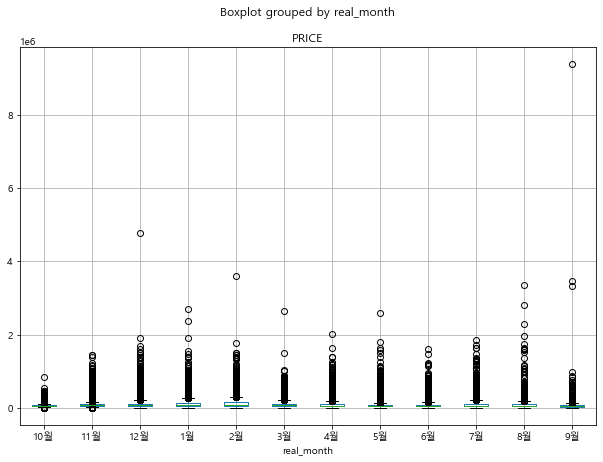

In [28]:
###### 월별 총 구매 금액의 최대값과 최소값, 평균값 등을 비교하기 위해 상자 차트로 표시한다.
agg_data.boxplot(column=['PRICE'], by='real_month', figsize=(10, 7))

In [29]:
# 500,000원 미만으로 Filter
# 구매 금액의 총합이 50만원 미만인 고객을 추출하여 고객 수를 확인한다.
cust4 = cust3.copy()
cust4 = cust3[cust3['PRICE'] < 500000]
cust4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450218 entries, 0 to 452092
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   CUST_SERIAL_NO  450218 non-null  int64
 1   month           450218 non-null  int64
 2   PRICE           450218 non-null  int64
dtypes: int64(3)
memory usage: 13.7 MB


<AxesSubplot:title={'center':'PRICE'}, xlabel='real_month'>

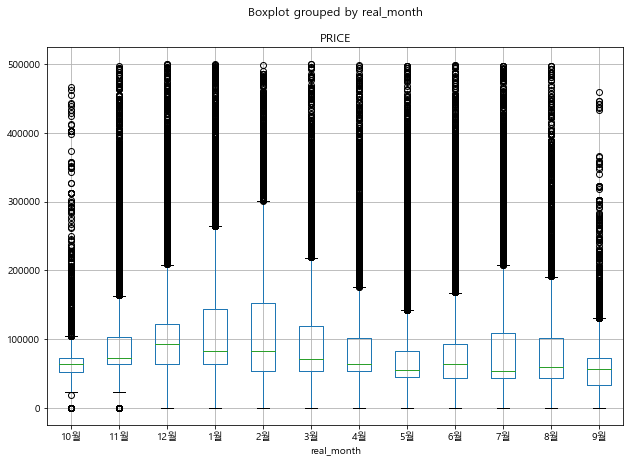

In [30]:
# 월별 총 구매 금액이 50만원 미만인 구매에 대해서 최대값과 최소값, 평균값 등을 비교하기 위해 상자 차트로 표시한다.
agg_data[agg_data['PRICE'] < 500000].boxplot(column=['PRICE'],
                                             by='real_month',
                                             figsize=(10, 7))

In [31]:
# 요일별 구매 금액 합계
# 구매 요일, 구매 건수만 추출하여 별도의 데이터 프레임을 만든다.
day1 = df[['ORDER_WEEKDAY', 'PRICE']]
day1.head()

,ORDER_WEEKDAY,PRICE
0,토,61500
1,토,42500
2,토,42500
3,일,53400
4,일,33400


In [32]:
# ddply() 함수를 사용하여 요일별로 구매 금액을 합쳐서 확인한다.
day2 = day1.copy
day2 = day1.groupby(['ORDER_WEEKDAY'])['PRICE'].sum().reset_index()
day2

,ORDER_WEEKDAY,PRICE
0,금,5482837830
1,목,5172669070
2,수,5182188030
3,월,5582784440
4,일,6875077420
5,토,6955078820
6,화,5319236280


In [33]:
# ddply() 함수를 사용하여 요일별로 구매 금액을 합친 결과를 agg_data_summary에 저장한다.
agg_data_summary = day2.copy()
agg_data_summary.columns = ['ORDER_WEEKDAY', 'Sum_F']
agg_data_summary

,ORDER_WEEKDAY,Sum_F
0,금,5482837830
1,목,5172669070
2,수,5182188030
3,월,5582784440
4,일,6875077420
5,토,6955078820
6,화,5319236280


In [34]:
# 그래프에 출력될 때 자동으로 정렬해서 출력되도록 요일 앞에 1부터 7까지의 숫자를 붙이는 함수를 만들어서 적용한다.
def change_r_day(x):
    if x == "월":
        return ("1_월")
    elif x == "화":
        return ("2_화")
    elif x == "수":
        return ("3_수")
    elif x == "목":
        return ("4_목")
    elif x == "금":
        return ("5_금")
    elif x == "토":
        return ("6_토")
    else:
        return ("7_일")


agg_data_summary['rday'] = agg_data_summary['ORDER_WEEKDAY'].apply(
    lambda x: change_r_day(x))
agg_data_summary

,ORDER_WEEKDAY,Sum_F,rday
0,금,5482837830,5_금
1,목,5172669070,4_목
2,수,5182188030,3_수
3,월,5582784440,1_월
4,일,6875077420,7_일
5,토,6955078820,6_토
6,화,5319236280,2_화


Text(0, 0.5, 'Sum_F')

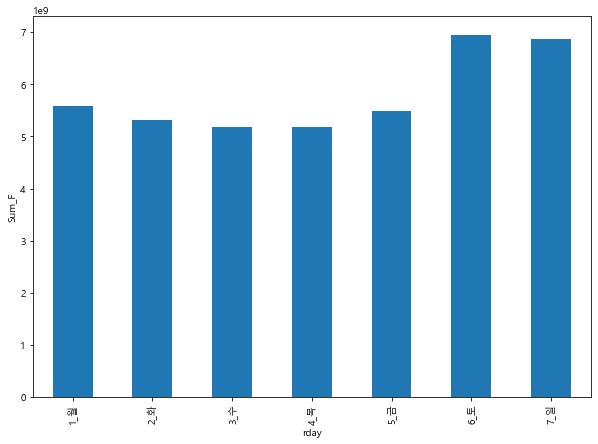

In [35]:
# 요일별 구매 금액의 총합을 막대 그래프로 표시한다.
field = "rday"
day_order = ["1_월", "2_화", "3_수", "4_목", "5_금", "6_토", "7_일"]
ax = agg_data_summary.set_index(field).loc[day_order].plot(kind="bar",
                                                           legend=False,
                                                           figsize=(10, 7))
ax.set_ylabel("Sum_F")

In [36]:
# 요일별 구매 상품 수
# ddply() 함수를 사용하여 요일별로 구매 수량을 합친 결과를 day_amt2에 저장하고, 요일 이름 변경 함수를 적용하여 rday 열을 추가한다. # nolint
day_amt1 = df[['ORDER_WEEKDAY', 'QTY']]
day_amt2 = day_amt1.groupby(['ORDER_WEEKDAY'])['QTY'].sum().reset_index()
day_amt2.columns = ['ORDER_WEEKDAY', 'Sum_F']
day_amt2

,ORDER_WEEKDAY,Sum_F
0,금,71678
1,목,69676
2,수,69839
3,월,72920
4,일,89851
5,토,91848
6,화,71744


<AxesSubplot:title={'center':'QTY'}, xlabel='ORDER_WEEKDAY'>

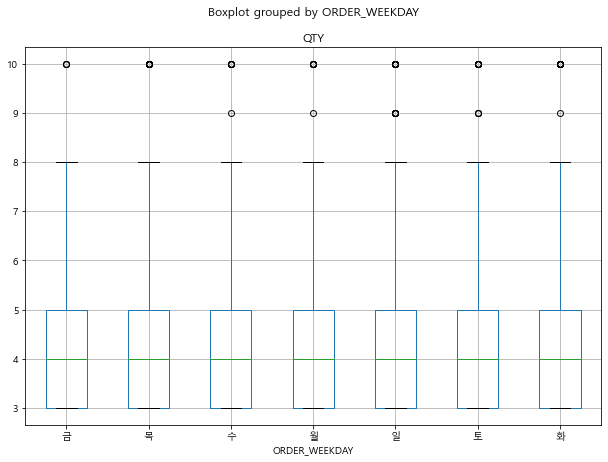

In [37]:
# 요일별 총 구매 수량이 2개를 초과하는 구매에 대해서 최대값과 최소값, 평균값 등을 비교하기 위해 상자 차트로 표시한다.
tmp = day_amt1[day_amt1['QTY'] > 2]
tmp.boxplot(column=['QTY'], by='ORDER_WEEKDAY', figsize=(10, 7))

In [38]:
# 전체 고객의 구매수량 상위 100개의 세 분류 상품에 대하여 wordcloud 표현
# 상품 분류 코드와 구매 수량 데이터만 추출한 다음 동일한 상품 분류 코드에 대한 누적 구매 수량을 구한다.
dgroup1 = df[['LGROUP', 'MGROUP', 'SGROUP', 'DGROUP', 'QTY']]
dgroup1.head()
dgroup2 = dgroup1.groupby(['LGROUP', 'MGROUP', 'SGROUP',
                           'DGROUP'])['QTY'].sum().reset_index()
dgroup2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   LGROUP  275 non-null    int64
 1   MGROUP  275 non-null    int64
 2   SGROUP  275 non-null    int64
 3   DGROUP  275 non-null    int64
 4   QTY     275 non-null    int64
dtypes: int64(5)
memory usage: 10.9 KB


In [39]:
# 조인을 하기 위해서, 4개의 상품 분류 코드를 하나의 문자열로 합친 다음 LMSD_ICODE 열에 저장한다.
dgroup2['LMSD_ICODE'] = dgroup2['LGROUP'].astype(str) + "|" + dgroup2[
    'MGROUP'].astype(str) + "|" + dgroup2['SGROUP'].astype(
        str) + "|" + dgroup2['DGROUP'].astype(str)

In [40]:
# 상품 분류 코드에 따른 분류 이름이 저장된 CSV 파일을 읽은 다음, 역시 조인을 하기 위해서, 4개의 상품 분류 코드를 하나의 문자열로 합친 다음 LMSD_ICODE 열에 저장한다. # nolint
vhd = pd.read_csv(f"{data_path}/VHD_GOODSKIND.csv")
vhd['LMSD_ICODE'] = vhd['LGROUP'].astype(str) + "|" + vhd['MGROUP'].astype(
    str) + "|" + vhd['SGROUP'].astype(str) + "|" + vhd['DGROUP'].astype(str)
vhd.head()

,LGROUP,MGROUP,SGROUP,DGROUP,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,LMSD_CODE,LMSD_ICODE
0,70,2,1,2,식품,신선식품/가공식품,간편/즉석식품,기타 간편/즉석식품,70020102,70|2|1|2
1,70,2,1,3,식품,신선식품/가공식품,간편/즉석식품,덮밥/덮밥소스,70020103,70|2|1|3
2,70,2,1,4,식품,신선식품/가공식품,간편/즉석식품,만두/딤섬,70020104,70|2|1|4
3,70,2,1,5,식품,신선식품/가공식품,간편/즉석식품,분말짜장/카레,70020105,70|2|1|5
4,70,2,1,6,식품,신선식품/가공식품,간편/즉석식품,샐러드,70020106,70|2|1|6


In [41]:
# 두 개의 데이터 프레임을 LMSD_ICODE 열을 기준으로 조인하여 합치고 구매수량 기준으로 내림차순 정렬을 한다.
vhd2 = vhd[['LMSD_ICODE', 'DGROUP_NAME']]
dgroup2 = pd.merge(dgroup2, vhd2, on='LMSD_ICODE')
dgroup3 = dgroup2.sort_values(by=['QTY'], ascending=False)
dgroup3.head()

,LGROUP,MGROUP,SGROUP,DGROUP,QTY,LMSD_ICODE,DGROUP_NAME
45,10,14,11,3,27127,10|14|11|3,바지
140,50,1,2,4,23331,50|1|2|4,드라이버/전동드릴
239,80,2,9,4,21886,80|2|9|4,세차/외장/편의용품
136,50,1,1,1,19722,50|1|1|1,건강베개/숙면용품
46,10,14,11,4,15725,10|14|11|4,반팔


In [42]:
# dgroup3에서 상위 100개의 합계만 추출하여 별도의 벡터로 만든다.
vec1 = []
for j in range(100):
    vec1.append(dgroup3.iloc[j]['QTY'])

vec1[:5]

[27127, 23331, 21886, 19722, 15725]

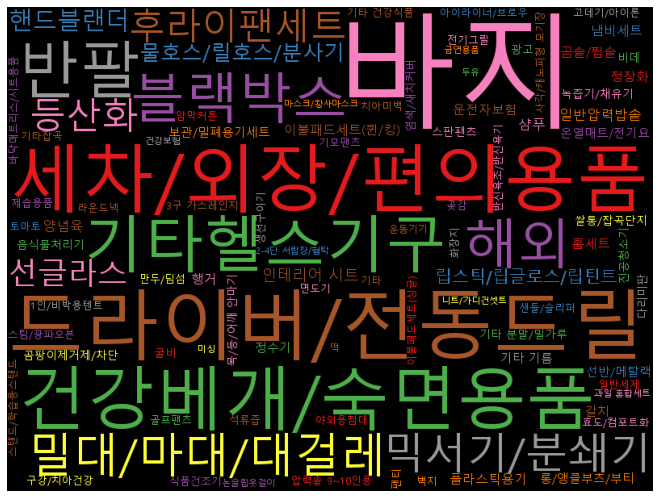

In [43]:
# wordcloud를 이용하여 상위 100개의 상품 세 분류 이름을 시각화 한다.
products = {}
for index, product in enumerate(dgroup3['DGROUP_NAME'][:100]):
    if product not in products:
        products[product] = vec1[index]

palettes = 'Set1'
wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
               colormap=palettes,
               width=800,
               height=600)
cloud = wc.generate_from_frequencies(products)

plt.figure(figsize=(10, 7))
plt.axis('off')
plt.tight_layout(pad=1)
plt.imshow(cloud)
plt.show()

In [44]:
# 연관성 분석을 통한 상품 추천
# 구매 내역 중 "패션/잡화"와 "뷰티" 대분류에 대한 연관성을 분석한다.
# LGROUP이 10(패션/잡화)이거나 20(뷰티)인 항목을 추출하여 anal_df에 저장한다. 고객 번호와 구매 월, 구매 요일을 이용하여 ID를 생성하고 조인을 위해 LMSD_ICODE도 추가한다.  # nolint
anal_df = df[(df['LGROUP'] == 10) | (df['LGROUP'] == 20)]
anal_df['month'] = pd.DatetimeIndex(anal_df['ORDER_DATE']).month

anal_df['ID'] = anal_df['CUST_SERIAL_NO'].astype(str) + ' ' + anal_df[
    'month'].astype(str) + ' ' + anal_df['ORDER_WEEKDAY'].astype(str) + ' _'

anal_df['LMSD_ICODE'] = anal_df['LGROUP'].astype(str) + "|" + anal_df[
    'MGROUP'].astype(str) + "|" + anal_df['SGROUP'].astype(
        str) + "|" + anal_df['DGROUP'].astype(str)

anal_df = pd.merge(anal_df, vhd2, on="LMSD_ICODE")
anal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143107 entries, 0 to 143106
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   CUST_SERIAL_NO  143107 non-null  int64 
 1   SEX             143107 non-null  object
 2   AGE             143107 non-null  object
 3   REG_DATE        143107 non-null  object
 4   ORDER_DATE      143107 non-null  object
 5   ORDER_HOUR      143107 non-null  object
 6   ORDER_WEEKDAY   143107 non-null  object
 7   IS_WEEKEND      143107 non-null  object
 8   GOODS_CODE      143107 non-null  int64 
 9   LGROUP          143107 non-null  int64 
 10  MGROUP          143107 non-null  int64 
 11  SGROUP          143107 non-null  int64 
 12  DGROUP          143107 non-null  int64 
 13  GOODS_NAME      143107 non-null  object
 14  PRICE           143107 non-null  int64 
 15  QTY             143107 non-null  int64 
 16  month           143107 non-null  int64 
 17  ID              143107 non-nu

In [45]:
# 분석을 위한 변수들을 선택한다.
anal_df = anal_df[["ID", "DGROUP_NAME"]]

In [79]:
# 연관성 분석을 위해서 리스트 형식으로 변환 한다.
records = anal_df.groupby(['ID'])['DGROUP_NAME'].apply(list).reset_index()
records = list(records['DGROUP_NAME'])
records[:5]

[['립스틱/립글로스/립틴트'],
 ['샌들/슬리퍼', '샌들/슬리퍼'],
 ['립스틱/립글로스/립틴트'],
 ['골프팬츠'],
 ['효도/컴포트화']]

In [67]:
te = TransactionEncoder()
te_ary = te.fit_transform(records, sparse=True)
te_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
te_df.head()

,거들팬티,경등산화(트레킹화),고데기/아이론,골프팬츠,공용선글라스,기내용 캐리어,기능성웨어,기모팬츠,기타,남성내복(세트),...,파운데이션,패션가발,패턴/스트라이프니트,팩/마스크,팬티,페이스오일,피부&바디마사지/관리기,헤어젤/스프레이,효도/컴포트화,후드/맨투맨
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
# apriori() 함수를 사용하여 연관성 분석을 수행한다. 분석 결과를 적절하게 도출하려면 support 값과 confidence 값을 조절하면서 분석을 수행해야 한다. # nolint
frequent_itemset = apriori(te_df,
                           min_support=0.0001,
                           use_colnames=True,
                           verbose=1)
frequent_itemset['length'] = frequent_itemset['itemsets'].map(lambda x: len(x))
frequent_itemset.sort_values('support', ascending=True, inplace=True)

Processing 327 combinations | Sampling itemset size 32


In [69]:
len(frequent_itemset)

81

In [70]:
frequent_itemset[:5]

,support,itemsets,length
73,0.000104,"(아이라이너/브로우, 립스틱/립글로스/립틴트)",2
48,0.000104,(진주),1
76,0.000111,"(샴푸, 바지)",2
72,0.000111,"(반팔, 롱/앵클부츠/부티)",2
29,0.000126,(비비크림),1


In [71]:
association_rules_df = association_rules(
    frequent_itemset,
    metric='confidence',
    min_threshold=0.0001,
)

In [72]:
association_rules_df[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(아이라이너/브로우),(립스틱/립글로스/립틴트),0.019644,0.075250,0.000104,0.005291,0.070313,-0.001374,0.929669
1,(립스틱/립글로스/립틴트),(아이라이너/브로우),0.075250,0.019644,0.000104,0.001381,0.070313,-0.001374,0.981712
2,(샴푸),(바지),0.046898,0.211206,0.000111,0.002375,0.011243,-0.009794,0.790672
3,(바지),(샴푸),0.211206,0.046898,0.000111,0.000527,0.011243,-0.009794,0.953605
4,(반팔),(롱/앵클부츠/부티),0.154412,0.031545,0.000111,0.000721,0.022862,-0.004760,0.969154


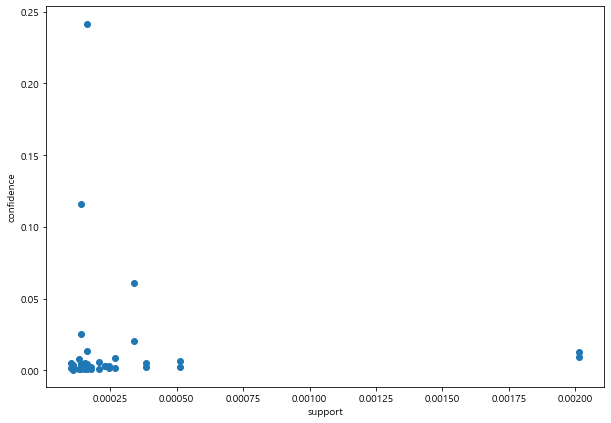

In [73]:
# 78개의 룰에 대한 분석 결과를 시각화 한다.
support = association_rules_df['support']
confidence = association_rules_df['confidence']

plt.figure(figsize=(10, 7))
scatter = plt.scatter(support, confidence)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

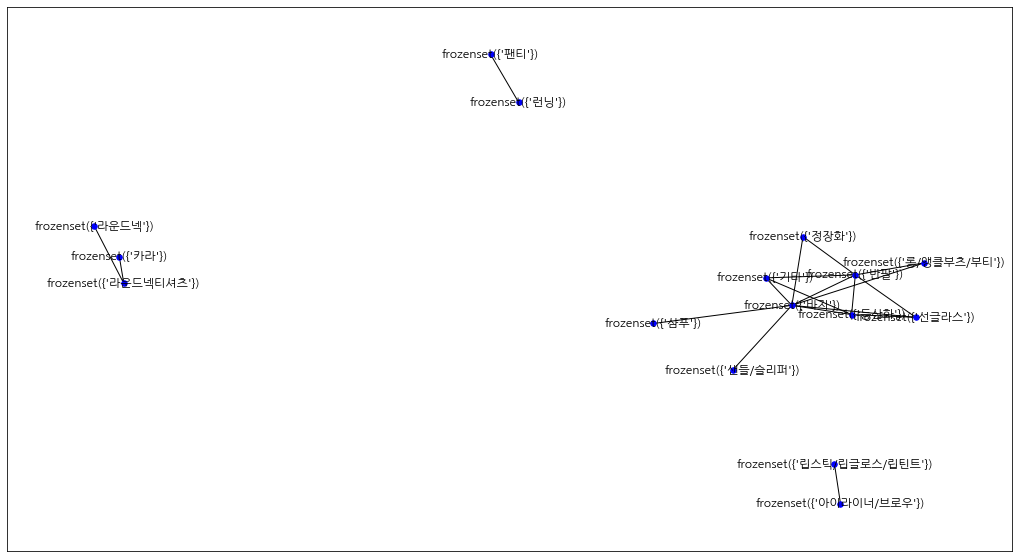

In [74]:
# 각 상품에 대한 연관성을 관계도를 이용하여 보여준다. 이를 통해서 대분류별 1회 구매 시에 구매 특성을 알 수 있다.
g = nx.Graph()
g = nx.from_pandas_edgelist(association_rules_df,
                            source='antecedents',
                            target='consequents')

plt.figure(figsize=(18, 10))
pos = nx.spring_layout(g, k=0.5)
nx.draw_networkx(g,
                 pos,
                 node_size=30,
                 node_color='blue',
                 font_family='NanumGothic')
plt.show()

In [75]:
# 연관성 분석 결과를 CSV 파일로 저장한다.
association_rules_df.to_csv('result.csv')

In [76]:
# 등산화 한가지 분류에 대한 룰을 선택하여 시각화
# 연관성 분석을 수행한 결과 만들어지는 arules_result에서 등산화 관련 부분만 추출한다.
test = association_rules_df[
    association_rules_df['antecedents'].astype(str).str.contains('등산화')
    | association_rules_df['consequents'].astype(str).str.contains('등산화')]

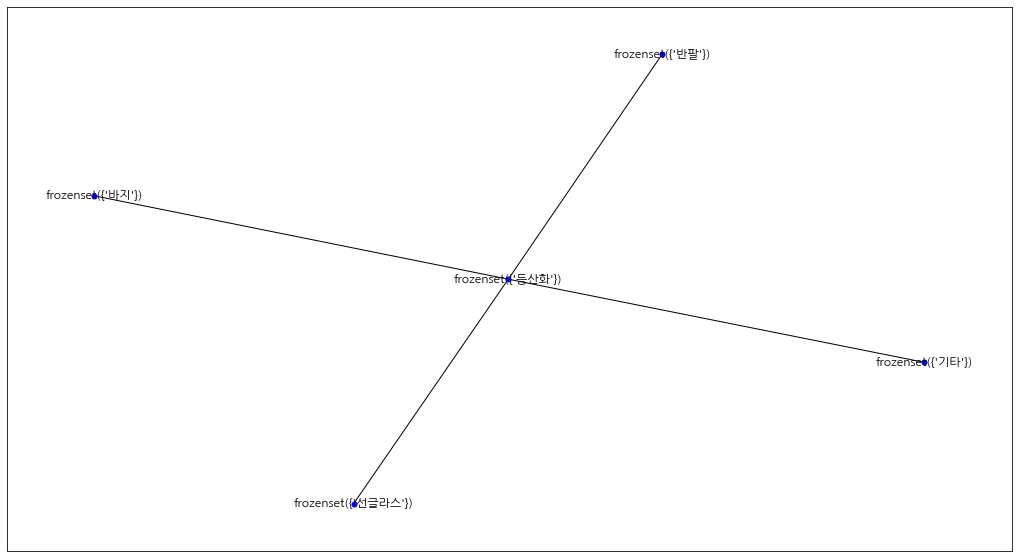

In [77]:
# 반팔이나 바지를 구매한 고객은 등산화도 같이 구매하는 연관성을 도출했다. 따라서, 향후 고객들이 반팔이나 바지를 구매할 때 등산화 구매를 추천해줄 수 있다. # nolint
g = nx.Graph()
g = nx.from_pandas_edgelist(test, source='antecedents', target='consequents')

plt.figure(figsize=(18, 10))
pos = nx.spring_layout(g, k=0.5)
nx.draw_networkx(g,
                 pos,
                 node_size=25,
                 node_color='blue',
                 font_family='NanumGothic')
plt.show()

In [78]:
# groupby 1.43s
records = anal_df.groupby(['ID'])['DGROUP_NAME'].apply(list).reset_index()
records = list(records['DGROUP_NAME'])

In [182]:
# np for 7m 5s
tmp_arr = anal_df.to_numpy()
tmp_uni = np.unique(tmp_arr[:, 0])
tmp_r = [
    tmp_arr[np.where(tmp_arr[:, 0] == _id)][:, 1] for _id in tqdm(tmp_uni)
]

100%|██████████████████████| 134698/134698 [07:05<00:00, 316.82it/s]


In [63]:
# df for 19m 4s
uni_id = list(pd.unique(anal_df['ID']))
records = []
for _id in tqdm(uni_id):
    dname = list(anal_df[anal_df['ID'] == _id]['DGROUP_NAME'])
    records.append(dname)

records[:5]

100%|██████████████████████| 134698/134698 [19:04<00:00, 117.74it/s]


[['남성세트'], ['남성세트'], ['남성세트'], ['남성세트'], ['남성세트']]